To evaluate edge or curvature preservation between LiDAR and Gaussian models, we'll use PCA to estimate curvature at each point based on eigenvalues. Here's how:

Steps:
Import Required Libraries:

trimesh for 3D model handling.
numpy for computations.
matplotlib for plotting.
Load Models:

Load Gaussian and LiDAR models separately using trimesh.
Compute Curvature:

Use PCA on neighborhoods to estimate curvature.
Evaluate Errors:

Compare distances of corresponding high-curvature points.
Visualization:

Plot error vs curvature and scatter plots of curvature vs distance error.
Save Figures:

Save results in the specified directory.


Model: Natural
  Average Curvature: 0.0044
  Distance Error (Mean ± Std): 1.2611 ± 1.0010

Model: Accidental
  Average Curvature: 0.0059
  Distance Error (Mean ± Std): 0.8700 ± 0.8500

Model: Homicidal
  Average Curvature: 0.0052
  Distance Error (Mean ± Std): 0.3210 ± 0.3107


/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
/opt/anaconda3/lib/python3.8/site-packag


Model: Suicidal
  Average Curvature: nan
  Distance Error (Mean ± Std): 0.4794 ± 0.4893

Model: Undetermined
  Average Curvature: 0.0032
  Distance Error (Mean ± Std): 0.9264 ± 0.7750


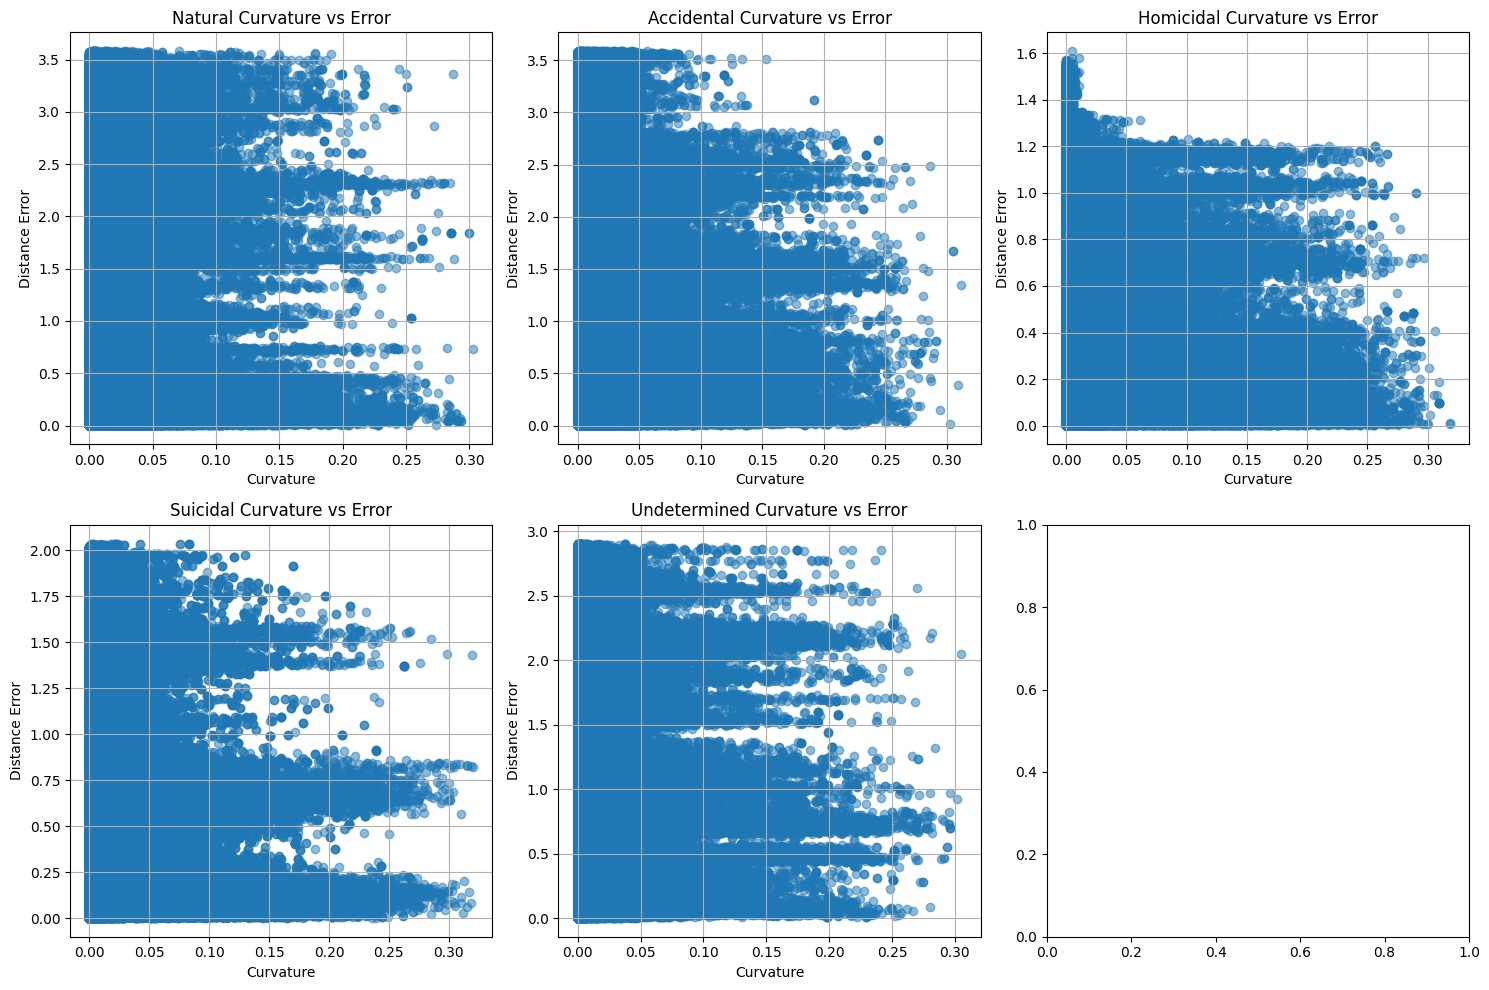

In [3]:
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

# Function to compute curvature using PCA over local neighborhoods
def compute_curvature(points, k=10):
    # Construct a KDTree for quick neighborhood searches
    tree = cKDTree(points)
    curvatures = []

    # Iterate over each point to calculate curvature
    for point in points:
        # Find k nearest neighbors
        distances, indices = tree.query(point, k=k+1)  # include the point itself

        # Perform PCA on neighborhood
        neighbors = points[indices]
        pca = PCA(n_components=3)
        pca.fit(neighbors)

        # Estimate curvature as the ratio of the smallest eigenvalue to the sum of eigenvalues
        eigenvalues = pca.explained_variance_ratio_
        curvature_value = eigenvalues[-1] / sum(eigenvalues)
        curvatures.append(curvature_value)

    return np.array(curvatures)

# Function to estimate curvature and error
def estimate_curvature_and_error(lidar_mesh, gaussian_mesh):
    # Compute curvatures
    lidar_curvature = compute_curvature(lidar_mesh.vertices)
    gaussian_curvature = compute_curvature(gaussian_mesh.vertices)

    # Find nearest points from Gaussian to LiDAR
    _, closest_points_indices = gaussian_mesh.kdtree.query(lidar_mesh.vertices)
    closest_points = gaussian_mesh.vertices[closest_points_indices]

    # Compute errors as distances
    errors = np.linalg.norm(closest_points - lidar_mesh.vertices, axis=1)
    
    return lidar_curvature, errors

model_names = ['Natural', 'Accidental', 'Homicidal', 'Suicidal', 'Undetermined']

# Load Gaussian Models
gaussian_models = {
    'Natural': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Natural/3DGS.ply'),
    'Accidental': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Accidental/3DGS.ply'),
    'Homicidal': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Homicidal/3DGS.ply'),
    'Suicidal': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Suicidal/3DGS.ply'),
    'Undetermined': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Undetermined/3DGS.ply')
}

# Load LiDAR Models
lidar_models = {
    'Natural': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Natural/LiDARPLY/AdvancedExport/3DModel.ply'),
    'Accidental': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Accidental/LiDARPLY/AdvancedExport/3DModel.ply'),
    'Homicidal': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Homicidal/LiDARPLY/AdvancedExport/3DModel.ply'),
    'Suicidal': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Suicidal/LiDARPLY/AdvancedExport/3DModel.ply'),
    'Undetermined': trimesh.load('/Users/aaeshahalhakamy/MyResearch/Forensics/Scenes/Undetermined/LiDARPLY/AdvancedExport/3DModel.ply')
}

# Store results
results = {}

for category in model_names:
    # Compute curvature and error
    lidar_curvature, errors = estimate_curvature_and_error(lidar_models[category], gaussian_models[category])
    
    # Print results
    print(f"\nModel: {category}")
    print(f"  Average Curvature: {np.mean(lidar_curvature):.4f}")
    print(f"  Distance Error (Mean ± Std): {np.mean(errors):.4f} ± {np.std(errors):.4f}")
    
    # Save results
    results[category] = (lidar_curvature, errors)

# Visualization and saving
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for idx, (category, (curvature, errors)) in enumerate(results.items()):
    axes[idx].scatter(curvature, errors, alpha=0.5)
    axes[idx].set_title(f'{category} Curvature vs Error')
    axes[idx].set_xlabel('Curvature')
    axes[idx].set_ylabel('Distance Error')
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig('Images/curvature_vs_error_combined.png', dpi=200)
plt.show()